In [1]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
from matplotlib.pyplot import cm
import matplotlib.image as mpimg
from astropy.visualization import time_support
from sunpy import timeseries as ts
from sunpy.net import Fido
from sunpy.net import attrs as a
import datetime
from collections import OrderedDict
from pandas import DataFrame
import astropy.units as u
from astropy.time import Time, TimeDelta
import sunpy.data.sample
import sunpy.timeseries
from sunpy.net import Fido
from sunpy.time import TimeRange, parse_time
from sunpy.util.metadata import MetaDict

'''
import csv
 
# opening the CSV file
with open('Langmuir waves analysis/25-04-2002/WI_H1_WAV_23030.csv', mode ='r')as file:
   
  # reading the CSV file
  csvFile = csv.reader(file)
 
  # displaying the contents of the CSV file
  for lines in csvFile:
        print(lines)
'''

'''
File Specifications:
25/4/2002 5:56:34 file no. 23030 channels_1 = 7 channels_2 = 15 channels_3 = 15, goes_num = 10
17/11/2006 22:32:30 file no. 22677 channels_1 = 7 channels_2 = 15 channels_3 = 15, goes_num = 11
18/04/2014 12:55:50 file no. 233050 channels_1 = 7 channels_2 = 15 channels_3 = 14, goes_num = 15
26/04/2003 3:5:54 file no. 48697 channels_1 = 7 channels_2 = 15 channels_3 = 14, goes_num = 10
30/05/2002 5:21:14 file no. 174096 channels_1 = 7 channels_2 = 15 channels_3 = 15, goes_num = 10
11/04/2002 16:24:22 file no. 177636 channels_1 = 7 channels_2 = 15 channels_3 = 9, goes_num = 10
'''

#---------------------------------------------
# Insert what you need

# GOES specifics
tstart = "2003-04-26 02:00"
tend = "2003-04-26 06:00"
goes_num = 10 # choose GOES instrument

event_start_time = dt.datetime(2003,4,26,3,5,54) # peak time of the event yyyy,mm,dd,HH,MM,SS

# Define path
file_no = str(48697)
date_for_path = '26-04-2003'

# Choose appropriate channels
channels_1 = 7 # bottom channels
channels_2 = 15 # top channels
channels_3 = 14 # middle channels
#---------------------------------------------

f2_header = 46 # 6 eV to 1113 eV 
f3_header = 51 # 200 eV to 27 keV 
f1_header = 72 # 27 keV up 
spec_header = 43

path = 'Langmuir waves analysis/' + date_for_path + '/'
spec_name = 'WI_H1_WAV_' + file_no + '.csv'
f2_name = 'WI_ELSP_3DP_' + file_no + '.csv' # ELSP
f3_name = 'WI_EHSP_3DP_' + file_no + '.csv' # EHSP
f1_name = 'WI_SFSP_3DP_' + file_no + '.csv' # SFSP

#rhessi_date = '_20140418'
#rhessi_timeinterval = '_120000_160000'
#rhessi_filepath = 'Langmuir waves analysis/' + date_for_path + '/' + 'goes_rhessi' + rhessi_date + rhessi_timeinterval + '.eps'

init_channels_1 = 0
init_channels_2 = 0
init_channels_3 = 0

def arrival_time(E):
    m = 9.1e-31
    v = np.sqrt(3.2e-16 * E/m)
    dist = 215*7e8
    t = dist/v
    return event_start_time + dt.timedelta(0,t) 


C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
result = Fido.search(a.Time(tstart, tend), a.Instrument("XRS"))
print(result)

Results from 1 Provider:

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        Instrument ... Source Provider
----------------------- ----------------------- ---------- ... ------ --------
2003-04-26 00:00:00.000 2003-04-26 23:59:59.999        XRS ...   GOES     NOAA




In [3]:
result_goes = Fido.search(a.Time(tstart, tend), a.Instrument("XRS"), a.goes.SatelliteNumber(goes_num))
print(result_goes)

Results from 1 Provider:

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        Instrument ... Source Provider
----------------------- ----------------------- ---------- ... ------ --------
2003-04-26 00:00:00.000 2003-04-26 23:59:59.999        XRS ...   GOES     NOAA




In [4]:
file_goes = Fido.fetch(result_goes)

Files Downloaded: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/file]


In [5]:
results_RHESSI = Fido.search(a.Time(tstart, tend),
                      a.Instrument.rhessi, a.Physobs.summary_lightcurve)  
RHESSI = Fido.fetch(results_RHESSI)

Files Downloaded: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41file/s]


C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


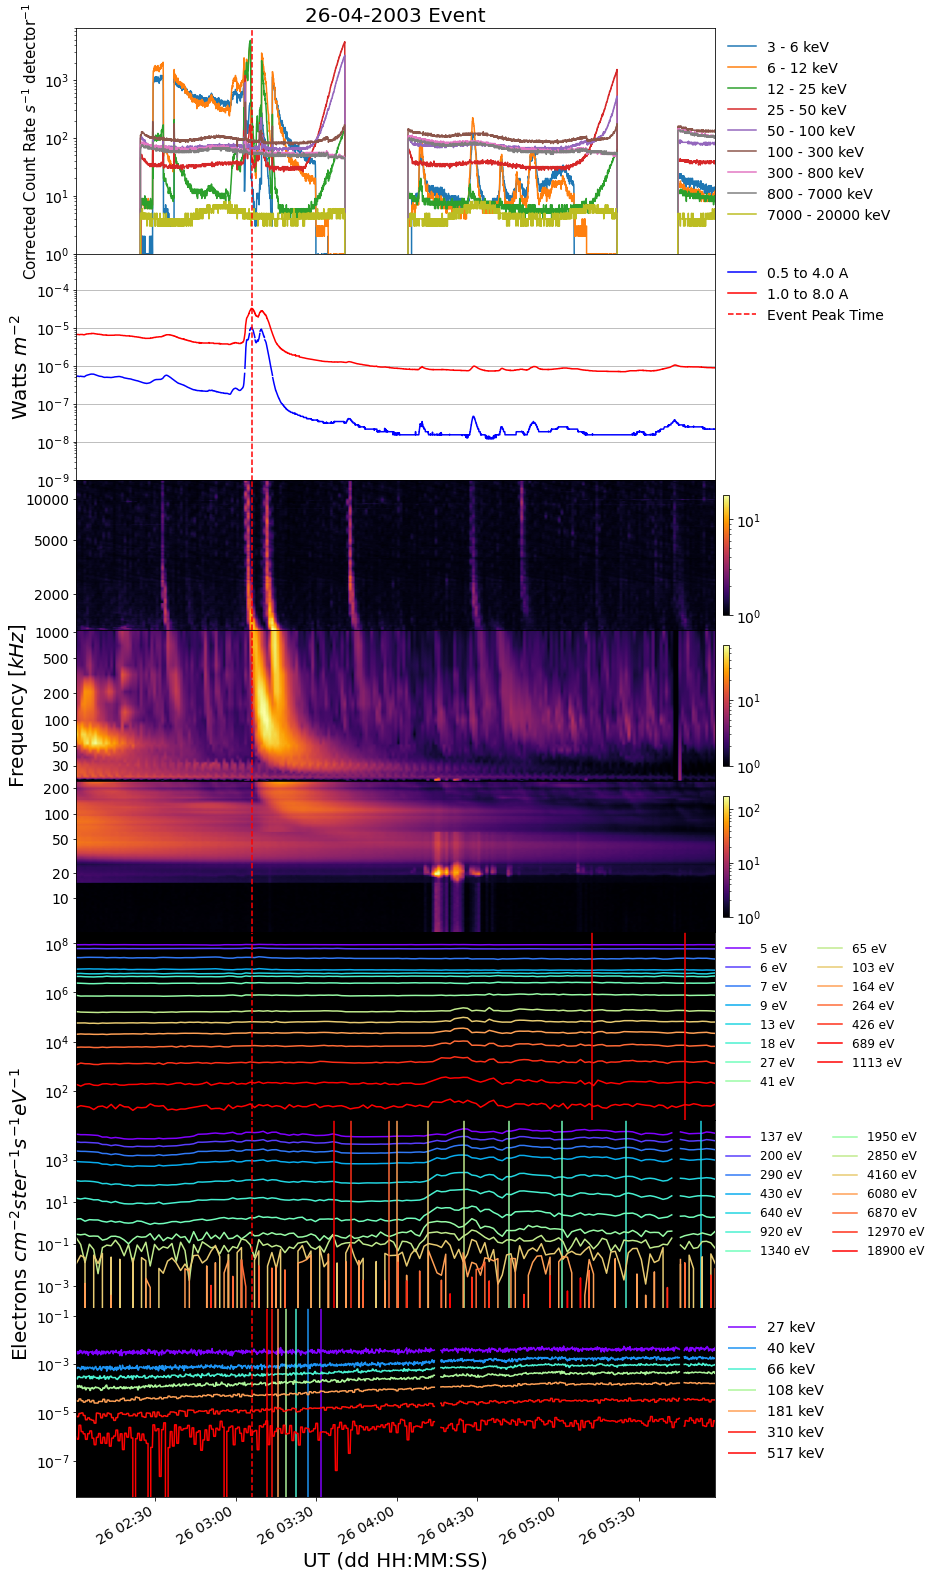

In [15]:

df_spec = pd.read_csv(path + spec_name, header=spec_header, skipfooter=3)
df_spec['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df_spec['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'], format = '%Y-%m-%dT%H:%M:%S.%fZ')

dates_list = df_spec['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'].to_list()
x_lims_ = [dates_list[0], dates_list[-1]]
#x_lims = list(map(dt.datetime.fromtimestamp, x_lims_))
x_lims = mdates.date2num(x_lims_)

y_lims0 = np.linspace(1075, 13825, 100)
y_lims1 = np.linspace(20, 1040, 100)
y_lims2 = np.linspace(4, 245, 100)

ratios0=[1,0]
ratios1=[1,0.19099]
ratios_goes = [1,0.191]
ratios_rhessi = [1,0.191]
col_posit = 0.01
shrink_c = 0.8

@plt.FuncFormatter
def fake_log(x, pos):
    'The two args are the value and tick position'
    return round(10**x) #r'$10^{%.2f}$' % (x)

df_spec = df_spec.set_index('EPOCH_yyyy-mm-ddThh:mm:ss.sssZ')
df_spec = df_spec[df_spec.columns[::-1]].T

df_spec0 = df_spec.iloc[353:-1, :]
df_spec1 = df_spec.iloc[95:353, :]
df_spec2 = df_spec.iloc[0:95, :]

date_format = mdates.DateFormatter('%H:%M:%S')
locator = mdates.HourLocator([4, 5, 6, 7, 8, 9])

plt.rc('ytick', labelsize=14)
plt.rc('xtick', labelsize=14)


fig = plt.figure(figsize=(15,30))
ax = fig.add_gridspec(4, 1, hspace=0, height_ratios=[0.4,0.4,0.8,1])

ax_rhessi = ax[0].subgridspec(1, 2, hspace=0, width_ratios=ratios_rhessi)
ax_goes = ax[1].subgridspec(1, 2, hspace=0, width_ratios=ratios_goes)
ax_0 = ax[2].subgridspec(3, 2, hspace=0, width_ratios=ratios0)
ax_1 = ax[3].subgridspec(3, 2, hspace=0, width_ratios=ratios1)

axrhessi = fig.add_subplot(ax_rhessi[0, 0])
axrhessi_fake = fig.add_subplot(ax_rhessi[0, 1])

axgoes = fig.add_subplot(ax_goes[0, 0])
axgoes_fake = fig.add_subplot(ax_goes[0, 1])

ax0 = [fig.add_subplot(ax_0[0, 0]), fig.add_subplot(ax_0[1, 0]), fig.add_subplot(ax_0[2, 0])]
ax0_fake = [fig.add_subplot(ax_0[0, 1]), fig.add_subplot(ax_0[1, 1]), fig.add_subplot(ax_0[2, 1])]


ax1 = [fig.add_subplot(ax_1[0, 0]), fig.add_subplot(ax_1[1, 0]), fig.add_subplot(ax_1[2, 0])]
ax1_fake = [fig.add_subplot(ax_1[0, 1]), fig.add_subplot(ax_1[1, 1]), fig.add_subplot(ax_1[2, 1])]


flare_time = mdates.date2num(event_start_time)

ts_rhessi = sunpy.timeseries.TimeSeries(RHESSI.data[0], source='RHESSI')
RHESSI_data = ts_rhessi.to_dataframe()

n_cols = RHESSI_data.shape[1] 

RHESSI_time = mdates.date2num(RHESSI_data.index)
RHESSI_time = RHESSI_time[::1]
k = 0

while k < n_cols:
    data_to_plot = RHESSI_data.iloc[::1,k].tolist()
    axrhessi.plot(RHESSI_time, data_to_plot, label = RHESSI_data.columns[k]) 
    k += 1

RHESSI_len = len(RHESSI.data)

if RHESSI_len > 1:
    iterel = 1
    while iterel < RHESSI_len:
        ts_rhessi = sunpy.timeseries.TimeSeries(RHESSI.data[iterel], source='RHESSI')
        RHESSI_data = ts_rhessi.to_dataframe()

        n_cols = RHESSI_data.shape[1] 

        RHESSI_time = mdates.date2num(RHESSI_data.index)
        RHESSI_time = RHESSI_time[::1]
        k = 0

        while k < n_cols:
            data_to_plot = RHESSI_data.iloc[::1,k].tolist()
            axrhessi.plot(RHESSI_time, data_to_plot) 
            k += 1
        iterel += 1
    
    

goes_ = ts.TimeSeries(file_goes[0])

goes_a = goes_.data['xrsa'].tolist()
goes_b = goes_.data['xrsb'].tolist()
goes_time = mdates.date2num(goes_.data.index)

axgoes.plot(goes_time, goes_a, 'b', label='0.5 to 4.0 A')
axgoes.plot(goes_time, goes_b, 'r', label='1.0 to 8.0 A')

n = len(file_goes)
if n > 1:
    iterat = 1
    while iterat < n:
        goes_ = ts.TimeSeries(file_goes[iterat])
        goes_a = goes_.data['xrsa'].tolist()
        goes_b = goes_.data['xrsb'].tolist()
        goes_time = mdates.date2num(goes_.data.index)
        axgoes.plot(goes_time, goes_a, 'b')
        axgoes.plot(goes_time, goes_b, 'r')
        iterat += 1


for a in ax1:
    a.set_anchor('W')

for a in ax1:
    a.patch.set_facecolor('black')

for a in ax0:
    a.patch.set_facecolor('black')

df_spec0 = df_spec0.clip(lower=1)
im = ax0[0].imshow(df_spec0, norm=colors.LogNorm(), cmap=cm.inferno,
                  extent = [x_lims[0], x_lims[1],  np.log10(y_lims0[0]), np.log10(y_lims0[-1])], aspect='auto')
fig.colorbar(im, ax=ax0[0], pad=col_posit, shrink=shrink_c)

ax0[0].xaxis.set(major_formatter=date_format)
ax0[0].tick_params(bottom = False)
ax0[0].set_xticks([])
ax0[0].yaxis.set_major_formatter(fake_log)
ax0[0].yaxis.set_major_locator(MaxNLocator(5)) 
ax0[0].set_yticks(np.log10(np.array([2000, 5000, 10000])))


#df_spec1*=10 # multiplies every element by 10
df_spec1 = df_spec1.clip(lower=1)
im = ax0[1].imshow(df_spec1, norm=colors.LogNorm(), cmap=cm.inferno,
                  extent = [x_lims[0], x_lims[1],  np.log10(y_lims1[0]), np.log10(y_lims1[-1])], aspect='auto')
fig.colorbar(im, ax=ax0[1], pad=col_posit, shrink=shrink_c)

ax0[1].xaxis.set(major_formatter=date_format)
ax0[1].tick_params(bottom = False)
ax0[1].set_xticks([])
ax0[1].yaxis.set_major_formatter(fake_log)
ax0[1].yaxis.set_major_locator(MaxNLocator(5)) 
ax0[1].set_yticks(np.log10(np.array([30, 50, 100, 200, 500, 1000])))

df_spec2 = df_spec2.clip(lower=1)
im = ax0[2].imshow(df_spec2, norm=colors.LogNorm(), cmap=cm.inferno, 
                  extent = [x_lims[0], x_lims[1],  np.log10(y_lims2[0]), np.log10(y_lims2[-1])], aspect='auto')
fig.colorbar(im, ax=ax0[2], pad=col_posit, shrink=shrink_c)

ax0[2].xaxis.set(major_formatter=date_format)
ax0[2].tick_params(bottom = False)
ax0[2].set_xticks([])
ax0[2].yaxis.set_major_formatter(fake_log)
ax0[2].yaxis.set_major_locator(MaxNLocator(5)) 
ax0[2].set_yticks(np.log10(np.array([10, 20, 50, 100, 200])))

#second set of images

df1 = pd.read_csv(path + f1_name, header=f1_header, skipfooter=3)
df1['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df1['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'], format = '%Y-%m-%dT%H:%M:%S.%fZ')

df2 = pd.read_csv(path + f2_name, header=f2_header, skipfooter=3)
df2['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df2['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'], format = '%Y-%m-%dT%H:%M:%S.%fZ')

df3 = pd.read_csv(path + f3_name, header=f3_header, skipfooter=3)
df3['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df3['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'], format = '%Y-%m-%dT%H:%M:%S.%fZ')


i1, i2, i3 = init_channels_1 , init_channels_2, init_channels_3
energies1 = [27, 40, 66, 108, 181, 310, 517]
energies2 = list(np.array([5, 6, 7, 9, 13, 18, 27, 41, 65, 103, 164, 264, 426, 689, 1113])*1e-3)
energies3 = [0.137, 0.2, 0.29, 0.43, 0.64, 0.92, 1.34, 1.95, 2.85, 4.16, 6.08, 6.87, 12.97, 18.9, 27]


while i1<= channels_1 - 1 :
    ax1[2].plot(df1.iloc[:, 0], df1.iloc[:, i1+1], c=cm.rainbow([50*i1]))
    ax1[2].vlines(arrival_time(energies1[i1]), 0,0.3, color=cm.rainbow([50*i1]), label = str(energies1[i1]) + ' keV')
    ax1[2].set_xlim(df3.iloc[0, 0], df3.iloc[-1, 0])
    ax1[2].set_yscale("log")
    plt.gcf().autofmt_xdate()
    i1 += 1

while i2 < channels_2 :
    init_indx2 = 1 + init_channels_2
    df2_channels = df2.iloc[:, init_indx2:16]
    df2_reversed = df2_channels[df2_channels.columns[::-1]]
    ax1[0].plot(df2.iloc[:, 0], df2_reversed.iloc[:, i2], c=cm.rainbow([20*i2]), label = str(round(energies2[i2]*1e3)) + ' eV')
    ax1[0].vlines(arrival_time(energies2[i2]), 0,4e8, color=cm.rainbow([20*i2]))
    ax1[0].set_xlim(df3.iloc[0, 0], df3.iloc[-1, 0])
    ax1[0].set_yscale("log")
    i2 += 1

while i3 < channels_3 :
    init_indx3 = 1 + init_channels_3
    df3_channels = df3.iloc[:, init_indx3:16]
    df3_reversed = df3_channels[df3_channels.columns[::-1]]
    ax1[1].plot(df3.iloc[:, 0], df3_reversed.iloc[:, i3], c=cm.rainbow([20*i3]), label = str(round(energies3[i3]*1e3)) + ' eV')
    ax1[1].vlines(arrival_time(energies3[i3]), 0,1e5, color=cm.rainbow([20*i3]))
    ax1[1].set_xlim(df3.iloc[0, 0], df3.iloc[-1, 0])
    ax1[1].set_yscale("log")
    i3 += 1


ax0[0].vlines(flare_time, np.log10(y_lims0[0]), np.log10(y_lims0[-1]), 'r', linestyle='--')
ax0[1].vlines(flare_time, np.log10(y_lims1[0]), np.log10(y_lims1[-1]), 'r', linestyle='--')
ax0[2].vlines(flare_time, np.log10(y_lims2[0]), np.log10(y_lims2[-1]), 'r', linestyle='--')

ax1[0].vlines(flare_time, -1, 1e9, 'r', linestyle='--')
ax1[1].vlines(flare_time, -1, 1e9, 'r', linestyle='--')
ax1[2].vlines(flare_time, -1, 1e9, 'r', linestyle='--')

ax1[1].set_ylim(None, 8e4)
ax1[0].set_ylim(top=3e8)
ax1[2].set_ylim(top=0.2)

ax0[0].set_xlim(df3.iloc[0, 0], df3.iloc[-1, 0])
ax0[1].set_xlim(df3.iloc[0, 0], df3.iloc[-1, 0])
ax0[2].set_xlim(df3.iloc[0, 0], df3.iloc[-1, 0])

ax1[0].set_xlim(df3.iloc[0, 0], df3.iloc[-1, 0])
ax1[1].set_xlim(df3.iloc[0, 0], df3.iloc[-1, 0])
ax1[2].set_xlim(df3.iloc[0, 0], df3.iloc[-1, 0])

ax1[0].set_xticks([])
ax1[1].set_xticks([])
ax1[0].legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize = 12, frameon=False, ncol=2)
ax1[1].legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize = 12, frameon=False, ncol=2)
ax1[2].legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize = 14, frameon=False)
ax1[2].set_xlabel('UT (dd HH:MM:SS)', fontsize = 20)
ax0[1].set_ylabel('Frequency $[kHz]$', fontsize = 20)
ax1[1].set_ylabel('Electrons $cm^{-2} ster^{-1} s^{-1} eV^{-1}$', fontsize = 20)

axgoes.set_xlim(df3.iloc[0, 0], df3.iloc[-1, 0])
axgoes.vlines(flare_time, -1, 1, 'r', linestyle='--', label = 'Event Peak Time')
axgoes.set_ylim(1e-9, 0.0009)
axgoes.set_yscale("log")
axgoes.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 14, frameon=False)
axgoes.grid(axis='y')
axgoes.set_ylabel('Watts $m^{-2}$', fontsize = 20)

axrhessi.set_xlim(df3.iloc[0, 0], df3.iloc[-1, 0])
axrhessi.vlines(flare_time, -1, 10000, 'r', linestyle='--')
axrhessi.set_ylim(1, 8000)
axrhessi.set_yscale("log")
axrhessi.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 14, frameon=False)
axrhessi.set_ylabel('Corrected Count Rate $s^{-1}$ detector$^{-1}$', fontsize = 15)
axrhessi.set_title(date_for_path + ' Event', fontsize = 20)


for a in ax1_fake:
    a.set_visible(False)

for a in ax0_fake:
    a.set_visible(False)

axgoes_fake.set_visible(False)
axrhessi_fake.set_visible(False)

plt.savefig(path + "Spec_Plot_" + date_for_path, bbox_inches='tight')

In [7]:
'''# RHESSI.data
from astropy.io import fits
hdu = fits.open(RHESSI.data[0])
hdu[6].data
hdu[0].header'''

'# RHESSI.data\nfrom astropy.io import fits\nhdu = fits.open(RHESSI.data[0])\nhdu[6].data\nhdu[0].header'

In [8]:
'''ts_eve = sunpy.timeseries.TimeSeries(sunpy.data.sample.EVE_TIMESERIES, source='EVE')
ts_goes = sunpy.timeseries.TimeSeries(sunpy.data.sample.GOES_XRS_TIMESERIES, source='XRS')
ts_lyra = sunpy.timeseries.TimeSeries(sunpy.data.sample.LYRA_LEVEL3_TIMESERIES, source='LYRA')
ts_norh = sunpy.timeseries.TimeSeries(sunpy.data.sample.NORH_TIMESERIES, source='NoRH')
ts_rhessi = sunpy.timeseries.TimeSeries(sunpy.data.sample.RHESSI_TIMESERIES, source='RHESSI')
ts_gbm = sunpy.timeseries.TimeSeries(sunpy.data.sample.GBM_TIMESERIES, source='GBMSummary')'''

"ts_eve = sunpy.timeseries.TimeSeries(sunpy.data.sample.EVE_TIMESERIES, source='EVE')\nts_goes = sunpy.timeseries.TimeSeries(sunpy.data.sample.GOES_XRS_TIMESERIES, source='XRS')\nts_lyra = sunpy.timeseries.TimeSeries(sunpy.data.sample.LYRA_LEVEL3_TIMESERIES, source='LYRA')\nts_norh = sunpy.timeseries.TimeSeries(sunpy.data.sample.NORH_TIMESERIES, source='NoRH')\nts_rhessi = sunpy.timeseries.TimeSeries(sunpy.data.sample.RHESSI_TIMESERIES, source='RHESSI')\nts_gbm = sunpy.timeseries.TimeSeries(sunpy.data.sample.GBM_TIMESERIES, source='GBMSummary')"

In [9]:
'''RHESSI = Fido.search(a.Time(tstart, tend), a.Instrument.rhessi)
RHESSI_files = Fido.fetch(RHESSI)

# Using these new files you get a list of timeseries
list_of_RHESSI_ts = sunpy.timeseries.TimeSeries(RHESSI_files, source='RHESSI')'''

"RHESSI = Fido.search(a.Time(tstart, tend), a.Instrument.rhessi)\nRHESSI_files = Fido.fetch(RHESSI)\n\n# Using these new files you get a list of timeseries\nlist_of_RHESSI_ts = sunpy.timeseries.TimeSeries(RHESSI_files, source='RHESSI')"

In [10]:
'''combined_RHESSI_ts = sunpy.timeseries.TimeSeries(RHESSI_files, source='RHESSI', concatenate=True)
# Manually
combined_RHESSI_ts = list_of_RHESSI_ts[0].concatenate(list_of_RHESSI_ts[1])
combined_RHESSI_ts.plot()

plt.show()'''

"combined_RHESSI_ts = sunpy.timeseries.TimeSeries(RHESSI_files, source='RHESSI', concatenate=True)\n# Manually\ncombined_RHESSI_ts = list_of_RHESSI_ts[0].concatenate(list_of_RHESSI_ts[1])\ncombined_RHESSI_ts.plot()\n\nplt.show()"

# How to download RHESSI data

In [11]:
from sunpy.net import Fido, attrs as a
results_RHESSI = Fido.search(a.Time(tstart, tend),
                      a.Instrument.rhessi, a.Physobs.summary_lightcurve)  
RHESSI = Fido.fetch(results_RHESSI)

Files Downloaded: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51file/s]


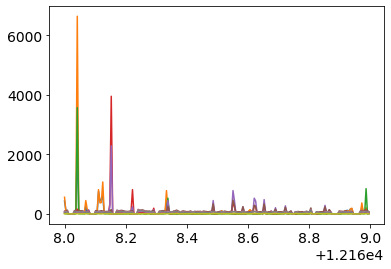

In [12]:
import datetime
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

import astropy.units as u
from astropy.time import Time, TimeDelta

import sunpy.data.sample
import sunpy.timeseries
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.time import TimeRange, parse_time
from sunpy.util.metadata import MetaDict

ts_rhessi = sunpy.timeseries.TimeSeries(RHESSI.data[0], source='RHESSI')

RHESSI_data = ts_rhessi.to_dataframe()

n_cols = RHESSI_data.shape[1] 

RHESSI_time = mdates.date2num(RHESSI_data.index)
RHESSI_time = RHESSI_time[::100]
i = 0

while i < n_cols:
    data_to_plot = RHESSI_data.iloc[::100,i].tolist()
    plt.plot(RHESSI_time, data_to_plot, label = RHESSI_data.columns[i]) 
    i += 1
